In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

group_backbones = {
    "convnext": [
        'convnext_tiny', 'robust_convnext_tiny', 'convnext_tiny.fb_in22k',
        'convnext_base', 'convnext_base.fb_in22k', 'robust_convnext_base',
        'convnext_base.clip_laion2b', 'convnext_base.clip_laion2b_augreg'
    ],
    "vit": [
        'deit_small_patch16_224.fb_in1k', 'robust_deit_small_patch16_224',
        'vit_base_patch16_224.augreg_in1k', 'vit_base_patch16_224.augreg_in21k',
        'vit_base_patch16_224.dino', 'vit_base_patch16_224.mae', 
        'vit_base_patch16_224.orig_in21k', 'vit_base_patch16_224.sam_in1k',
        'vit_base_patch16_224_miil.in21k', 'robust_vit_base_patch16_224' 
    ]
}

group_losses = {
    "trades_v2": ["TRADES_v2"],
    "classic_at": ["CLASSIC_AT"]
}

datas=( 'stanford_cars', 'caltech101', 'fgvc-aircraft-2013b', 'dtd', 'flowers-102', 'oxford-iiit-pet'  ) #'imagenette2' 'eurosat' 

losses=( 'TRADES_v2', 'CLASSIC_AT' ) #  

backbones=(
  'convnext_tiny', 'robust_convnext_tiny', 'convnext_tiny.fb_in22k', 
  'convnext_base', 'convnext_base.fb_in22k', 'robust_convnext_base', 
  'convnext_base.clip_laion2b', 'convnext_base.clip_laion2b_augreg',
  'deit_small_patch16_224.fb_in1k', 'robust_deit_small_patch16_224',
  'vit_base_patch16_224.augreg_in1k', 'vit_base_patch16_224.augreg_in21k',
  'vit_base_patch16_224.dino', 'vit_base_patch16_224.mae', 'vit_base_patch16_224.orig_in21k',
  'vit_base_patch16_224.sam_in1k', 'vit_base_patch16_224_miil.in21k', 'robust_vit_base_patch16_224'   ) 

final_data1 = []
final_data2 = []

for backbone in backbones:
    for loss in losses:
        for data in datas:

            try:

                name ='{}_{}_{}'.format(backbone, data, loss)
                project_name = 'full_fine_tuning_5epochs_final1'
                with open('./results/results_{}_{}_{}_{}.pkl'.format(project_name, backbone, data, loss), 'rb') as f:
                    saved_data = pickle.load(f)
                    result = saved_data[name]["statistics"]
                    result['backbone'] = backbone
                    result['dataset'] = data
                    result['loss_function'] = loss    
            except:
                result = {}
                result['backbone'] = backbone
                result['dataset'] = data
                result['loss_function'] = loss   
                result['clean_acc'] = np.nan
                result['robust_acc'] = np.nan 
                # print('not available')

            final_data1.append(result)

            try:

                name ='{}_{}_{}'.format(backbone, data, loss)
                project_name = 'full_fine_tuning_50epochs_final1'
                with open('./results/results_{}_{}_{}_{}.pkl'.format(project_name, backbone, data, loss), 'rb') as f:
                    saved_data = pickle.load(f)
                    result = saved_data[name]["statistics"]
                    result['backbone'] = backbone
                    result['dataset'] = data
                    result['loss_function'] = loss    
            except:
                result = {}
                result['backbone'] = backbone
                result['dataset'] = data
                result['loss_function'] = loss   
                result['clean_acc'] = np.nan
                result['robust_acc'] = np.nan 
                # print('not available')

            final_data2.append(result)

/home/mheuillet/Desktop/robust_training/.venv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-21 15:36:14,738	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-21 15:36:15,078	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/tmp/ipykernel_29474/1926264691.py:51: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public Num

In [2]:
import pandas as pd

df1 = pd.DataFrame(final_data1)
df2 = pd.DataFrame(final_data2)


In [3]:
for idx, data_updated in enumerate([ df1, df2 ]):

    # Combine clean_acc and robust_acc as independent metrics for ranking
    data_updated['total_acc'] = data_updated['clean_acc'] + data_updated['robust_acc']  # Sum of scores per dataset
    # data_updated['total_acc'] = data_updated['clean_acc'] 
    # data_updated['total_acc'] = data_updated['robust_acc']  # Sum of scores per dataset

    aggregated_data_no_avg = data_updated.groupby(['backbone', 'loss_function']).agg(
        total_sum=('total_acc', 'sum'),  # Total sum of all scores across datasets
        total_geom_mean=('total_acc', lambda x: np.prod(x) ** (1 / len(x))),  # Geometric mean
    ).reset_index()

    # Rank based on these combined scores
    aggregated_data_no_avg['rank_total_sum'] = aggregated_data_no_avg['total_sum'].rank(ascending=False)
    aggregated_data_no_avg['rank_total_geom_mean'] = aggregated_data_no_avg['total_geom_mean'].rank(ascending=False)

    # Sort by sum ranking for presentation
    ranked_aggregated_data_no_avg = aggregated_data_no_avg.sort_values(by='rank_total_sum')

    ranked_aggregated_data_no_avg

    ranked_aggregated_data_no_avg.to_csv('./results/ranked_aggregated_data_no_avg{}.csv'.format(idx+1) )

In [7]:
# Load the datasets

file_path_1 = 'results/ranked_aggregated_data_no_avg1.csv'
file_path_2 = 'results/ranked_aggregated_data_no_avg2.csv'

data1 = pd.read_csv(file_path_1)
data2 = pd.read_csv(file_path_2)

# Merge datasets based on backbone and loss_function

merged_data = pd.merge(
    data1[['backbone', 'loss_function', 'total_geom_mean', 'total_sum', 'rank_total_geom_mean', 'rank_total_sum']],
    data2[['backbone', 'loss_function', 'total_geom_mean', 'total_sum', 'rank_total_geom_mean', 'rank_total_sum']],
    on=['backbone', 'loss_function'],
    suffixes=('_1', '_2') )

# Calculate the difference between the total_geom_mean values
merged_data['difference_sum'] = merged_data['total_sum_2'] - merged_data['total_sum_1']
merged_data['difference_geom'] = merged_data['total_geom_mean_2'] - merged_data['total_geom_mean_1'] 

merged_data['difference_rank_sum'] = merged_data['rank_total_sum_1'] - merged_data['rank_total_sum_2'] 
merged_data['difference_rank_geom'] = merged_data['rank_total_geom_mean_1']  - merged_data['rank_total_geom_mean_2'] 

# Sort by backbone and loss_function for better visualization
merged_data.sort_values(by=['backbone', 'loss_function'], inplace=True)

/tmp/ipykernel_4976/2124904974.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.yticks(y_positions, merged_data[['backbone', 'loss_function']].apply(lambda x: f"{x[0]} | {x[1]}", axis=1))


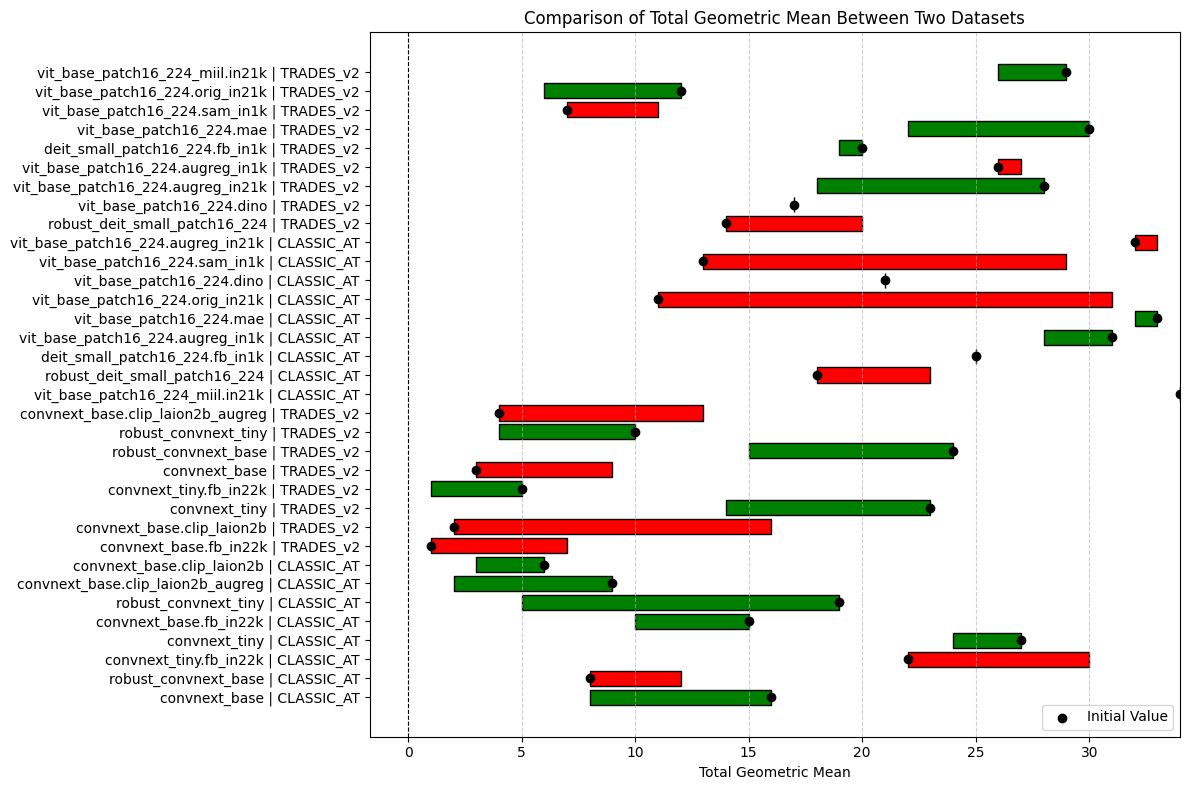

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Create group mapping functions
def map_backbone_group(backbone):
    for group, models in group_backbones.items():
        if backbone in models:
            return group
    return "other"

def map_loss_group(loss_function):
    for group, losses in group_losses.items():
        if loss_function in losses:
            return group
    return "other"

# Apply group mappings to the dataset
merged_data['backbone_group'] = merged_data['backbone'].apply(map_backbone_group)
merged_data['loss_group'] = merged_data['loss_function'].apply(map_loss_group)

# Sort data by groups
merged_data['group_order'] = merged_data['backbone_group'] + "_" + merged_data['loss_group']
merged_data = merged_data.sort_values(by='group_order', ascending=True)

# Update y_positions
y_positions = np.arange(len(merged_data))

# Plot
plt.figure(figsize=(12, 8))

# starting_points = merged_data['total_sum_1']
# differences = merged_data['difference_sum']
# starting_points = merged_data['total_geom_mean_1']
# differences = merged_data['difference_geom']

# plt.barh(
#     y_positions, differences, left=starting_points,
#     color=np.where(differences > 0, 'green', 'red'), edgecolor='black'
# )


starting_points = merged_data['rank_total_geom_mean_1']
differences = merged_data['difference_rank_geom']

plt.barh(
    y_positions, differences, left=starting_points,
    color=np.where(differences > 0, 'red', 'green'), edgecolor='black' )


plt.scatter(starting_points, y_positions, color='black', label='Initial Value', zorder=3)

# Add sorted labels
plt.yticks(y_positions, merged_data[['backbone', 'loss_function']].apply(lambda x: f"{x[0]} | {x[1]}", axis=1))
plt.xlabel("Total Geometric Mean")
plt.title("Comparison of Total Geometric Mean Between Two Datasets")
plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.legend()
plt.tight_layout()
plt.savefig("./figures/5_to_50_rankgeom")
plt.show()


In [8]:
merged_data.sort_values(by='difference_rank_sum')

,backbone,loss_function,total_geom_mean_1,total_sum_1,rank_total_geom_mean_1,rank_total_sum_1,total_geom_mean_2,total_sum_2,rank_total_geom_mean_2,rank_total_sum_2,difference_sum,difference_geom,difference_rank_sum,difference_rank_geom
2,convnext_base.clip_laion2b,TRADES_v2,1.117139,7.108667,2.0,3.0,1.296874,6.007333,16.0,28.0,-1.101333,0.179735,-25.0,-14.0
1,convnext_base,TRADES_v2,1.060291,7.362000,3.0,2.0,1.352528,6.395333,9.0,25.0,-0.966667,0.292237,-23.0,-6.0
0,convnext_base.fb_in22k,TRADES_v2,1.185647,7.726000,1.0,1.0,1.355899,6.416000,7.0,24.0,-1.310000,0.170252,-23.0,-6.0
4,convnext_base.clip_laion2b_augreg,TRADES_v2,1.015484,6.684000,4.0,5.0,1.335623,6.253333,13.0,26.0,-0.430667,0.320139,-21.0,-9.0
11,vit_base_patch16_224.orig_in21k,CLASSIC_AT,0.836598,6.129333,13.0,12.0,0.991681,5.292667,33.0,31.0,-0.836667,0.155083,-19.0,-20.0
15,vit_base_patch16_224.sam_in1k,CLASSIC_AT,0.831462,5.785333,15.0,16.0,1.024097,5.302667,29.0,30.0,-0.482667,0.192635,-14.0,-14.0
18,vit_base_patch16_224.augreg_in21k,CLASSIC_AT,0.253870,5.327000,34.0,19.0,0.526265,5.490000,35.0,29.0,0.163000,0.272396,-10.0,-1.0
13,robust_deit_small_patch16_224,TRADES_v2,0.828633,5.934000,16.0,14.0,1.247021,6.678000,20.0,22.0,0.744000,0.418388,-8.0,-4.0
8,vit_base_patch16_224.sam_in1k,TRADES_v2,0.907308,6.211667,9.0,9.0,1.343138,7.246667,11.0,13.0,1.035000,0.435830,-4.0,-2.0
9,robust_convnext_base,CLASSIC_AT,0.901682,6.157333,10.0,10.0,1.340066,7.230000,12.0,14.0,1.072667,0.438384,-4.0,-2.0


In [7]:


# Add group identifiers to the merged dataset
merged_data['backbone_group'] = merged_data['backbone'].apply(
    lambda x: next((group for group, backbones in group_backbones.items() if x in backbones), 'other')
)
merged_data['loss_group'] = merged_data['loss_function'].apply(
    lambda x: next((group for group, losses in group_losses.items() if x in losses), 'other')
)

# Group by backbone and loss group to compute statistics
grouped_stats = merged_data.groupby(['backbone_group', 'loss_group']).agg({
    'difference_sum': ['mean', 'median', 'std', 'count'],
    'difference_geom': ['mean',  'median', 'std', ],
    'difference_rank_sum': ['mean', 'median', 'std', ],
    'difference_rank_geom': ['mean',  'median', 'std', ],
}).reset_index()


In [8]:
grouped_stats

backbone_group  loss_group difference_sum                            \
                                       mean    median       std count   
0       convnext  classic_at       1.654792  1.250417  0.914734     8   
1       convnext   trades_v2       0.229458  0.283667  1.329277     8   
2            vit  classic_at       1.038704  1.362667  1.406662     9   
3            vit   trades_v2       1.792741  1.513333  1.183486     9   

  difference_geom                     difference_rank_sum                    \
             mean    median       std                mean median        std   
0        0.544807  0.534164  0.143148           -6.125000   -3.5   9.125122   
1        0.405262  0.362325  0.202332           10.125000   11.5  14.014661   
2        0.399639  0.517532  0.248917           -1.000000    0.0  13.500000   
3        0.631272  0.604503  0.166313           -2.555556   -1.0   7.682954   

  difference_rank_geom                   
                  mean median       std  
0            -3.500000   -4.0  6.907553  
1             0.875000    1.0  8.919281  
2             4.222222    0.0  8.151346  
3            -1.888889   -1.0  5.372254